## Workflow

1. Calculate EloDiff by taking both team's elos and adding adjustment factors. Gives us win probabilities/expected spreads (compare to Vegas??)
2. Game happens (simulate??)
3. Adjust elos based on result using various result-oriented adjustments (come up with new adjustments; i.e. plays vs expected...)
4. Repeat 1-3

In [2]:
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [56]:
g = pd.read_csv("nfl_elo.csv")

In [58]:
g = g[g['season'] >= 1960]
g.reset_index(drop=True,inplace=True)
g

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2
0,1960-09-09,1960,0,NaN,NE,DEN,1300.000000,1300.000000,0.592466,0.407534,...,0.566862,0.433138,12.540000,122.760000,1.254000,32.931770,1283.942071,1316.057929,10,13
1,1960-09-10,1960,0,NaN,LAC,KC,1300.000000,1300.000000,0.592466,0.407534,...,0.589531,0.410469,316.140000,153.120000,31.614000,11.872908,1305.532159,1294.467841,21,20
2,1960-09-11,1960,0,NaN,NYJ,BUF,1300.000000,1300.000000,0.592466,0.407534,...,0.534573,0.465427,116.820000,-67.650000,11.682000,36.502993,1329.638852,1270.361148,27,3
3,1960-09-11,1960,0,NaN,OAK,TEN,1300.000000,1300.000000,0.592466,0.407534,...,0.523584,0.476416,147.180000,238.920000,14.718000,86.530014,1270.748277,1329.251723,22,37
4,1960-09-16,1960,0,NaN,OAK,KC,1266.146000,1294.513000,0.552525,0.447475,...,0.556189,0.443811,-96.257257,185.463743,3.620474,29.231991,1237.400627,1327.815491,16,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13902,2021-01-17,2020,0,d,KC,CLE,1712.652090,1552.012725,0.785647,0.214353,...,0.789927,0.210073,252.952255,107.241204,271.760879,175.170110,1718.032247,1562.129125,22,17
13903,2021-01-17,2020,0,d,NO,TB,1704.051294,1645.074008,0.671212,0.328788,...,0.705859,0.294141,-58.497561,221.469763,198.244018,221.747091,1700.946212,1660.789489,20,30
13904,2021-01-24,2020,0,c,GB,TB,1715.623187,1679.186255,0.641968,0.358032,...,0.629191,0.370809,198.493608,121.078453,268.837927,211.680227,1665.877222,1684.319058,26,31
13905,2021-01-24,2020,0,c,KC,BUF,1719.618921,1719.974149,0.591972,0.408028,...,0.535637,0.464363,376.765350,241.765435,282.261326,270.137585,1742.902172,1681.289840,38,24


In [59]:
g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13907 entries, 0 to 13906
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            13907 non-null  object 
 1   season          13907 non-null  int64  
 2   neutral         13907 non-null  int64  
 3   playoff         548 non-null    object 
 4   team1           13907 non-null  object 
 5   team2           13907 non-null  object 
 6   elo1_pre        13907 non-null  float64
 7   elo2_pre        13907 non-null  float64
 8   elo_prob1       13907 non-null  float64
 9   elo_prob2       13907 non-null  float64
 10  elo1_post       13907 non-null  float64
 11  elo2_post       13907 non-null  float64
 12  qbelo1_pre      13907 non-null  float64
 13  qbelo2_pre      13907 non-null  float64
 14  qb1             13907 non-null  object 
 15  qb2             13907 non-null  object 
 16  qb1_value_pre   13907 non-null  float64
 17  qb2_value_pre   13907 non-null 

### Travel Distance

In [101]:
# Source: https://en.wikipedia.org/wiki/National_Football_League#Teams
stadium_dict = {
    'BUF' : (42.774,-78.787),
    'MIA' : (25.958,-80.239),
    'NE' : (42.091,-71.264),
    'NYJ' : (40.814,-74.074),
    'BAL' : (39.278,-76.623),
    'CIN' : (39.095,-84.516),
    'CLE' : (41.506,-81.699),
    'PIT' : (40.447,-80.016),
    'HOU' : (29.685,-95.411),
    'IND' : (39.760,-86.164),
    'JAX' : (30.324,-81.638),
    'TEN' : (36.166,-86.771),
    'DEN' : (39.744,-105.020),
    'KC' : (39.049,-94.484),
    'OAK' : (36.090,-115.184),
    'LAC' : (33.953, -118.339),
    'DAL' : (32.748,-97.093),
    'NYG' : (40.814,-74.074),
    'PHI' : (39.901,-75.168),
    'WSH' : (38.908,-76.864),
    'CHI' : (41.863,-87.617),
    'DET' : (42.340,-83.046),
    'GB' : (44.501,-88.062),
    'MIN' : (44.974,-93.258),
    'ATL' : (33.755,-84.401),
    'CAR' : (35.226,-80.853),
    'NO' : (29.951,-90.081),
    'TB' : (27.976,-82.503),
    'ARI' : (33.528,-112.263),
    'LAR' : (33.953,-118.339),
    'SF' : (37.403,-121.970),
    'SEA' : (47.595,-122.332)
}

In [95]:
def travel_dist(team1,team2):
    team1_in_radians = [radians(_) for _ in stadium_dict[team1]]
    team2_in_radians = [radians(_) for _ in stadium_dict[team2]]
    result = haversine_distances([team1_in_radians, team2_in_radians])
    result = result * 3958.8  # multiply by Earth radius to get miles
    return result[0][1]

In [96]:
g['travel_dist'] = g.apply(lambda x: travel_dist(x.team1, x.team2), axis=1)

In [97]:
g

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,travel_dist
0,1960-09-09,1960,0,NaN,NE,DEN,1300.000000,1300.000000,0.592466,0.407534,...,0.433138,12.540000,122.760000,1.254000,32.931770,1283.942071,1316.057929,10,13,1758.397757
1,1960-09-10,1960,0,NaN,LAC,KC,1300.000000,1300.000000,0.592466,0.407534,...,0.410469,316.140000,153.120000,31.614000,11.872908,1305.532159,1294.467841,21,20,1366.492482
2,1960-09-11,1960,0,NaN,NYJ,BUF,1300.000000,1300.000000,0.592466,0.407534,...,0.465427,116.820000,-67.650000,11.682000,36.502993,1329.638852,1270.361148,27,3,277.934437
3,1960-09-11,1960,0,NaN,OAK,TEN,1300.000000,1300.000000,0.592466,0.407534,...,0.476416,147.180000,238.920000,14.718000,86.530014,1270.748277,1329.251723,22,37,1579.931405
4,1960-09-16,1960,0,NaN,OAK,KC,1266.146000,1294.513000,0.552525,0.447475,...,0.443811,-96.257257,185.463743,3.620474,29.231991,1237.400627,1327.815491,16,34,1149.305476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13902,2021-01-17,2020,0,d,KC,CLE,1712.652090,1552.012725,0.785647,0.214353,...,0.210073,252.952255,107.241204,271.760879,175.170110,1718.032247,1562.129125,22,17,694.267613
13903,2021-01-17,2020,0,d,NO,TB,1704.051294,1645.074008,0.671212,0.328788,...,0.294141,-58.497561,221.469763,198.244018,221.747091,1700.946212,1660.789489,20,30,477.883806
13904,2021-01-24,2020,0,c,GB,TB,1715.623187,1679.186255,0.641968,0.358032,...,0.370809,198.493608,121.078453,268.837927,211.680227,1665.877222,1684.319058,26,31,1182.312458
13905,2021-01-24,2020,0,c,KC,BUF,1719.618921,1719.974149,0.591972,0.408028,...,0.464363,376.765350,241.765435,282.261326,270.137585,1742.902172,1681.289840,38,24,857.591565


### Rest Adjustment

In [102]:
import datetime

In [104]:
g['date'] = pd.to_datetime(g['date'])

In [127]:
for team in g['team1'].unique():
    mask = ((g['team1'] == team) | (g['team2'] == team))
    g2 = g[mask]
    for season in g2['season'].unique():
        mask = g2['season'] == season
        g3 = g2[mask]
        game = 1
        for team in g3['team1']
        if (g3['team1'] == team):
            g3['game_num1'] = game
            game += 1
        else:
            g3['team2'] = game
            game += 1

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [109]:
for team in g['team1'].unique():
    mask = d['team1'] == team
    g2 = g[mask]
    for season in g2['season'].unique():
        mask = g2['season'] == '{}'.format(season)
        g3 = g2[mask]
        #for stat in list(d5.iloc[:,16:80].columns):
        #    d5['{}_rolling'.format(stat)] = d5.rolling(window=5)['{}'.format(stat)].mean().shift(1)
        #d.update(d5)
        g3

TypeError: 'float' object is not subscriptable

In [106]:
g['days_between_games'] = pd.to_timedelta(g['date'])

TypeError: dtype datetime64[ns] cannot be converted to timedelta64[ns]

## Elo Ratings

Calculate Elo Diff between Team 1 (home) and Team 2 (away). This is where we can make several pre-game adjustments to account for travel, rest, playoffs, and who's playing.

### Adjustment Constants

In [ ]:
HFA = 33 if game['season'] == 2020 else 55

# rest adjustment = make dates datetime objects and take difference in days
# anything greater than 10 apply (circle back for slight difference for mini-bye)



In [ ]:
# Pre-game Elo difference including adjustments
elo_diff =  team1['elo'] - team2['elo']
            +
            #base home field plus travel for away
            (0 if game['neutral'] == 1 else HFA + (4 * g['travel_dist']/1000))
            +
            #rest adjustment home team
            (25 if game['off_bye_team1'] == 1 else 0)
            +
            #rest adjustment away team
            (-25 if game['off_bye_team2'] == 1 else 0)
            +
            

# MOVE EDA AFTER RATING CREATION!

## EDA

Distirbution of Elo's

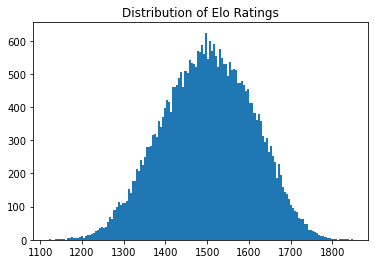

In [82]:
home_elo = g['elo1_post']
away_elo = g['elo2_post']
all_elo = pd.concat([home_elo,away_elo])

plt.hist(all_elo,
         bins=150)
plt.title('Distribution of Elo Ratings');

In [79]:
all_elo.mean()

1501.0169314135176

Change in Elo's

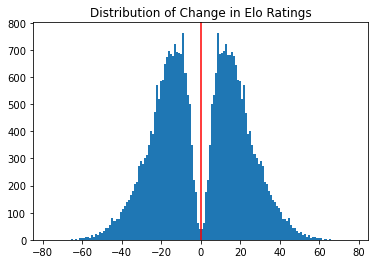

In [76]:
elo_delta1 = g['elo1_post'] - g['elo1_pre']
elo_delta2 = g['elo2_post'] - g['elo2_pre']
elo_delta = pd.concat([elo_delta1,elo_delta2])

plt.hist(elo_delta,
         bins=150)
plt.axvline(x=0, color='red')
plt.title('Distribution of Change in Elo Ratings');

# Evaluation

Create outcome columns to calculate Brier scores for both teams. This will be one of our evaluation metrics.

First we will get the tertiary outcome of each game (0 = loss, 0.5 = tie, and 1 = win), and then compare this outcome to our predicted probability. Since the probability adds to 1 and the outcome is (mostly) binary, we can evaluate one team for each game (both sides will return the same number). We can square this value to more penalize our biggest whiffs. The closer we are to 0 the better since that means we accurately predicted the correct outcome. 

Brier score = (Predicted outcome - Actual outcome)^2

Average Brier score would indicate how well we did for a given time frame, where as cumulative Brier score will highlight our biggest weaknesses. 

To illustrate, if we get Brier scores of 0.04, 0.04, and 0.64, our average Brier would be 0.24, which we can feel ok about, but a cumulative Brier score of 0.72 would not be great for 3 games, and we can investigate what caused this number to balloon and possibly improve the model more.

In [9]:
g['score_diff'] = g['score1'] - g['score2']

In [11]:
# functions to label winner/loser of each game for each team
def win_loss_team1(score_diff):
    if score_diff > 0:
        return 1
    elif score_diff == 0:
        return 0.5
    else:
        return 0

def win_loss_team2(score_diff):
    if score_diff < 0:
        return 1
    elif score_diff == 0:
        return 0.5
    else:
        return 0

In [12]:
g['team1_outcome'] = g['score_diff'].apply(win_loss_team1)
g['team2_outcome'] = g['score_diff'].apply(win_loss_team2)

In [14]:
g

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,score_diff,team1_outcome,team2_outcome
0,1920-09-26,1920,0,NaN,RII,STP,1503.947000,1300.000000,0.824651,0.175349,...,NaN,NaN,NaN,NaN,NaN,48,0,48,1.0,0.0
1,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688000,1300.000000,0.825267,0.174733,...,NaN,NaN,NaN,NaN,NaN,48,0,48,1.0,0.0
2,1920-10-03,1920,0,NaN,CHI,MUT,1368.333000,1300.000000,0.682986,0.317014,...,NaN,NaN,NaN,NaN,NaN,20,0,20,1.0,0.0
3,1920-10-03,1920,0,NaN,RII,MUN,1516.108000,1478.004000,0.644171,0.355829,...,NaN,NaN,NaN,NaN,NaN,45,0,45,1.0,0.0
4,1920-10-03,1920,0,NaN,DAY,COL,1493.002000,1504.908000,0.575819,0.424181,...,NaN,NaN,NaN,NaN,NaN,14,0,14,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16805,2021-01-17,2020,0,d,KC,CLE,1712.652090,1552.012725,0.785647,0.214353,...,107.241204,271.760879,175.170110,1718.032247,1562.129125,22,17,5,1.0,0.0
16806,2021-01-17,2020,0,d,NO,TB,1704.051294,1645.074008,0.671212,0.328788,...,221.469763,198.244018,221.747091,1700.946212,1660.789489,20,30,-10,0.0,1.0
16807,2021-01-24,2020,0,c,GB,TB,1715.623187,1679.186255,0.641968,0.358032,...,121.078453,268.837927,211.680227,1665.877222,1684.319058,26,31,-5,0.0,1.0
16808,2021-01-24,2020,0,c,KC,BUF,1719.618921,1719.974149,0.591972,0.408028,...,241.765435,282.261326,270.137585,1742.902172,1681.289840,38,24,14,1.0,0.0


In [18]:
g['Brier_og_elo'] = (g['elo_prob1'] - g['team1_outcome'])**2
g['Brier_2nd_elo'] = (g['qbelo_prob1'] - g['team1_outcome'])**2

In [19]:
g

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,score_diff,team1_outcome,team2_outcome,Brier_og_elo,Brier_2nd_elo
0,1920-09-26,1920,0,NaN,RII,STP,1503.947000,1300.000000,0.824651,0.175349,...,NaN,NaN,NaN,48,0,48,1.0,0.0,0.030747,NaN
1,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688000,1300.000000,0.825267,0.174733,...,NaN,NaN,NaN,48,0,48,1.0,0.0,0.030532,NaN
2,1920-10-03,1920,0,NaN,CHI,MUT,1368.333000,1300.000000,0.682986,0.317014,...,NaN,NaN,NaN,20,0,20,1.0,0.0,0.100498,NaN
3,1920-10-03,1920,0,NaN,RII,MUN,1516.108000,1478.004000,0.644171,0.355829,...,NaN,NaN,NaN,45,0,45,1.0,0.0,0.126614,NaN
4,1920-10-03,1920,0,NaN,DAY,COL,1493.002000,1504.908000,0.575819,0.424181,...,NaN,NaN,NaN,14,0,14,1.0,0.0,0.179929,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16805,2021-01-17,2020,0,d,KC,CLE,1712.652090,1552.012725,0.785647,0.214353,...,175.170110,1718.032247,1562.129125,22,17,5,1.0,0.0,0.045947,0.044130
16806,2021-01-17,2020,0,d,NO,TB,1704.051294,1645.074008,0.671212,0.328788,...,221.747091,1700.946212,1660.789489,20,30,-10,0.0,1.0,0.450525,0.498237
16807,2021-01-24,2020,0,c,GB,TB,1715.623187,1679.186255,0.641968,0.358032,...,211.680227,1665.877222,1684.319058,26,31,-5,0.0,1.0,0.412123,0.395881
16808,2021-01-24,2020,0,c,KC,BUF,1719.618921,1719.974149,0.591972,0.408028,...,270.137585,1742.902172,1681.289840,38,24,14,1.0,0.0,0.166487,0.215633


In [56]:
season_avg = g.groupby(['season']).mean()

Plot average Brier scores by season

## Don't forget to update with our Elo!!

In [ ]:
#g['Brier_my_elo'] = (g['elo_prob1'] - g['team1_outcome'])**2

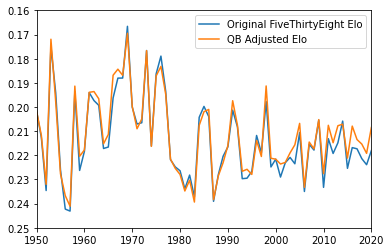

In [53]:
plt.plot(season_avg.index, season_avg['Brier_og_elo'],
                 label = 'Original FiveThirtyEight Elo')
plt.plot(season_avg.index, season_avg['Brier_2nd_elo'],
                 label = 'QB Adjusted Elo')

plt.xlim(1950,2020)
plt.ylim(0.16,0.25)
plt.gca().invert_yaxis()
plt.legend()
plt.show();

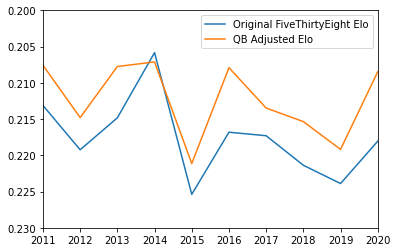

In [55]:
plt.plot(season_avg.index, season_avg['Brier_og_elo'],
                 label = 'Original FiveThirtyEight Elo')
plt.plot(season_avg.index, season_avg['Brier_2nd_elo'],
                 label = 'QB Adjusted Elo')

plt.xlim(2011,2020)
plt.ylim(0.20,0.23)
plt.gca().invert_yaxis()
plt.legend()
plt.show();

# Scratch Work

### Travel Distance

In [34]:
# Source: https://en.wikipedia.org/wiki/National_Football_League#Teams
stadium_dict = {
    'BUF' : (42.774,-78.787),
    'MIA' : (25.958,-80.239),
    'NE' : (42.091,-71.264),
    'NYJ' : (40.814,-74.074),
    'BAL' : (39.278,-76.623),
    'CIN' : (39.095,-84.516),
    'CLE' : (41.506,-81.699),
    'PIT' : (40.447,-80.016),
    'HOU' : (29.685,-95.411),
    'IND' : (39.760,-86.164),
    'JAX' : (30.324,-81.638),
    'TEN' : (36.166,-86.771),
    'DEN' : (39.744,-105.020),
    'KC' : (39.049,-94.484),
    'OAK' : (36.090,-115.184),
    'LAC' : (33.953, -118.339),
    'DAL' : (32.748,-97.093),
    'NYG' : (40.814,-74.074),
    'PHI' : (39.901,-75.168),
    'WSH' : (38.908,-76.864),
    'CHI' : (41.863,-87.617),
    'DET' : (42.340,-83.046),
    'GB' : (44.501,-88.062),
    'MIN' : (44.974,-93.258),
    'ATL' : (33.755,-84.401),
    'CAR' : (35.226,-80.853),
    'NO' : (29.951,-90.081),
    'TB' : (27.976,-82.503),
    'ARI' : (33.528,-112.263),
    'LAR' : (33.953,-118.339),
    'SF' : (37.403,-121.970),
    'SEA' : (47.595,-122.332)
}

In [80]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [98]:
def travel_dist(team1,team2):
    team1_in_radians = [radians(_) for _ in team1]
    team2_in_radians = [radians(_) for _ in team2]
    result = haversine_distances([team1_in_radians, team2_in_radians])
    result = result * 3958.8  # multiply by Earth radius to get miles
    return result[0][1]

In [100]:
travel_dist(stadium_dict['BUF'],stadium_dict['NE'])

386.40542413783044

In [ ]:
HFA = 65.0     # Home field advantage is worth 65 Elo points
K = 20.0       # The speed at which Elo ratings change
REVERT = 1/3.0 # Between seasons, a team retains 2/3 of its previous season's rating

REVERSIONS = {'CBD1925': 1502.032, 'RAC1926': 1403.384, 'LOU1926': 1307.201, 'CIB1927': 1362.919, 'MNN1929': 1306.702, # Some between-season reversions of unknown origin
              'BFF1929': 1331.943, 'LAR1944': 1373.977, 'PHI1944': 1497.988, 'ARI1945': 1353.939, 'PIT1945': 1353.939, 'CLE1999': 1300.0}

class Forecast:

    @staticmethod
    def forecast(games):
        """ Generates win probabilities in the my_prob1 field for each game based on Elo model """

        # Initialize team objects to maintain ratings
        teams = {}
        for row in [item for item in csv.DictReader(open("../initial_elos.csv"))]:
            teams[row['team']] = {
                'name': row['team'],
                'season': None,
                'elo': float(row['elo'])
            }

        for game in games:
            team1, team2 = teams[game['team1']], teams[game['team2']]

            # Revert teams at the start of seasons
            for team in [team1, team2]:
                if team['season'] and game['season'] != team['season']:
                    k = "%s%s" % (team['name'], game['season'])
                    if k in REVERSIONS:
                        team['elo'] = REVERSIONS[k]
                    else:
                        team['elo'] = 1505.0*REVERT + team['elo']*(1-REVERT)
                team['season'] = game['season']

            # Elo difference includes home field advantage
            elo_diff = team1['elo'] - team2['elo'] + (0 if game['neutral'] == 1 else HFA)

            # This is the most important piece, where we set my_prob1 to our forecasted probability
            if game['elo_prob1'] != None:
                game['my_prob1'] = 1.0 / (math.pow(10.0, (-elo_diff/400.0)) + 1.0)

            # If game was played, maintain team Elo ratings
            if game['score1'] != None:

                # Margin of victory is used as a K multiplier
                pd = abs(game['score1'] - game['score2'])
                mult = math.log(max(pd, 1) + 1.0) * (2.2 / (1.0 if game['result1'] == 0.5 else ((elo_diff if game['result1'] == 1.0 else -elo_diff) * 0.001 + 2.2)))

                # Elo shift based on K and the margin of victory multiplier
                shift = (K * mult) * (game['result1'] - game['my_prob1'])

                # Apply shift
                team1['elo'] += shift
                team2['elo'] -= shift